In [1]:
# Downgrade to a lower version of transformers to overcome the error
# TensorFlow and JAX classes are deprecated and
# will be removed in Transformers v5.
# We recommend migrating to PyTorch classes
# or pinning your version of Transformers.
# https://github.com/huggingface/transformers/issues/40028
# https://www.linkedin.com/pulse/hugging-face-drops-support-tensorflow-jax-revendra-t-ph-d-cppec/
# transformers<=4.54.1
!pip install transformers==4.54.1

# Does not work
# # https://stackoverflow.com/questions/78101520/valuerror-exception-encountered-when-calling-tf-distil-bert-model
# !pip uninstall -q transformers
# !pip uninstall -q sentence-transformers
# !pip install -q transformers==4.17

[RIGHT GPU](https://drlee.io/choosing-the-right-colab-runtime-a-guide-for-data-scientists-and-analysts-57ee7b7c9638)

In [2]:
import transformers

print(transformers.__version__)

4.54.1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import re
import warnings
warnings.filterwarnings("ignore")
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Input,Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Bidirectional

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Distilbert Model**

In [5]:
data = pd.read_csv("/content/data/final_filtered_annotated_reviews.csv")

In [6]:
data.shape

(13594, 2)

In [7]:
data.columns

Index(['the_review', 'topics'], dtype='object')

In [8]:
data.head()

,the_review,topics
0,I wish I would have gotten one earlier. I love...,mouse
1,It is so slow and lags find a better option,mouse
2,Beautifully produced and lovely to look at for...,mouse
3,I don't typically write reviews but I keep hav...,mouse
4,"I bought this in late June, it looks cool with...",mouse


### **Data Preprocessing**

In [ ]:
def preprocess(sent):
    '''Cleans text data up, leaving only 2 or
        more char long non-stopwords composed of A-Z & a-z only
        in lowercase'''
    # lowercase
    sentence = sent.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ",sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Removing digits
    sentence = sentence.translate(str.maketrans('', '', string.digits))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) 
    # When we remove apostrophe from the word "Mark's", 
    # the apostrophe is replaced by an empty space. 
    # Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Next, we remove all the single characters and replace it by a space 
    # which creates multiple spaces in our text. 
    # Finally, we remove the multiple spaces from our text as well.

    return sentence


In [10]:
text_cleaned = data.copy()
text_cleaned['cleaned_review'] = text_cleaned.the_review.apply(preprocess)

In [11]:
columns_needed = [
    "cleaned_review",
    "topics"
]

In [12]:
model_data = text_cleaned[columns_needed]

In [13]:
model_data.sample(2,random_state=42)

,cleaned_review,topics
1061,it is nice mouse and liked that it came with a...,mouse
3881,worth it,headphone


In [14]:
topics = model_data.topics.unique().tolist()
topics_mappings = {}
for index,value in enumerate(topics):
    topics_mappings[value]=index
topics_mappings

{'mouse': 0, 'headphone': 1, 'keyboard_speakers': 2}

In [15]:
model_data['topic_label'] = model_data.topics.map(topics_mappings)

In [16]:
model_data.head()

,cleaned_review,topics,topic_label
0,i wish would have gotten one earlier love it a...,mouse,0
1,it is so slow and lags find better option,mouse,0
2,beautifully produced and lovely to look at for...,mouse,0
3,i don typically write reviews but keep having ...,mouse,0
4,i bought this in late june it looks cool with ...,mouse,0


### **Downloading the Model**

In [17]:
from transformers import DistilBertTokenizer, TFDistilBertModel

In [18]:
# https://huggingface.co/distilbert/distilbert-base-uncased
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distil_uncased_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was tr

In [19]:

distil_uncased_model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.54.1",
  "vocab_size": 30522
}

In [20]:
distil_uncased_model.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# https://huggingface.co/docs/transformers/v4.26.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.encode_plus
# How tokenisation works
tokens = tokenizer.encode_plus(
    model_data.cleaned_review[0],
    max_length=285,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

In [22]:
tokens.input_ids

<tf.Tensor: shape=(1, 285), dtype=int32, numpy=
array([[  101,  1045,  4299,  2052,  2031,  5407,  2028,  3041,  2293,
         2009,  1998,  2009,  3084,  2551,  1999,  2026, 12191,  2061,
         2172,  6082,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [23]:
list(tokens.keys())

['input_ids', 'attention_mask']

In [24]:
tokens.attention_mask

<tf.Tensor: shape=(1, 285), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [25]:
tokens.input_ids.shape

TensorShape([1, 285])

In [26]:
tokens.attention_mask.shape

TensorShape([1, 285])

### **Model Training & Metrics**

In [27]:
# from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,\
ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline

# To be able to plot AUC_ROC curve
from sklearn.preprocessing import label_binarize

In [28]:
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
# https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html

In [29]:
y = model_data.topic_label

In [30]:
bin_classes = 3
y_binarize = label_binarize(y, classes=[0,1,2])

num_classes = y_binarize.shape[1]

In [31]:
# y_binarize
# array([[1, 0, 0],
#        [1, 0, 0],
#        [1, 0, 0],
#        ...,
#        [0, 0, 1],
#        [0, 0, 1],
#        [0, 0, 1]])

In [32]:
X = model_data[["cleaned_review"]]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binarize,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y_binarize)

**Define custom callbacks**

In [34]:
class MyCustomCallback(tf.keras.callbacks.Callback):
  def __init__(self):
     super(MyCustomCallback,self).__init__()

  def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            val_loss = logs.get("val_loss")
            loss = logs.get('loss')
            val_acc = logs.get('val_accuracy')
            acc = logs.get('accuracy')
            if val_loss < 0.2:
              print(f"\nValidation loss is less than 0.2. \nStopping training.\n")
              self.model.stop_training = True
            elif (val_acc >= 0.85 ) and (val_loss <= 0.2 ):
                print(f"\nValidation loss is <= 0.2 and val_acc >= 0.85\nStopping training.\n")
                self.model.stop_training = True
            elif (val_acc >= 0.85):
                print(f"\nValidation Accuracy, val_acc >= 0.85\nStopping training.\n")
                self.model.stop_training = True

callback = MyCustomCallback()

In [35]:
# optimizer
# optimize = tf.keras.optimizers.Adam(learning_rate=0.01)
optimize = tf.keras.optimizers.Adam(learning_rate=0.001)
# losses
loss = tf.keras.losses.categorical_crossentropy
# metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

**Text Sequencing**

In [36]:
tf.keras.backend.clear_session()
# tf.config.run_functions_eagerly(True)

In [37]:
X_train

,cleaned_review
681,i got this in the mint green color and like th...
11570,after months the jbl charge will no longer tak...
7384,got these for using the mic mic does not work ...
6628,i went through lot of wireless keyboards but t...
7911,you can use it for consle and still be able to...
...,...
2057,hi love it but bought it because it changed co...
5569,this came with an charging attachment but why ...
2,beautifully produced and lovely to look at for...
5016,like it very much great price great performanc...


In [38]:
# Resample the training data
under_sampler = RandomUnderSampler(random_state=42)

X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

In [39]:
X_input_ids = np.zeros((len(X_train_resampled),285), dtype=int)
X_attention_mask = np.zeros((len(X_train_resampled),285), dtype=int)

In [40]:
print(X_input_ids[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [41]:
print(X_input_ids.shape)

(8964, 285)


In [42]:
print(X_attention_mask.shape)

(8964, 285)


In [43]:
for key,text in enumerate(X_train_resampled['cleaned_review']):
  if key == 5:
    break
  else:
    print(text)

the type extension doesn work so it rendered it useless for my mac am able to use it on my pc for work just not the intended use bought it for the mouse itself is great light easy to use fits perfectly in my hand always connects and is reliable 
great product we use it mostly on our fire tablet and it works great only complaint is that there is not built in storage for the usb adapter 
 this mouse is lightweight it charges fast by small cable which is included it does not take batteries it puts on light show of colors fun for adults or children this can easily be turned off by switch on the bottom of the mouse the mouse itself is easy to assemble there is small usb plug that clips to the bottom of the mouse for storage when you are not using it this plugs into your computers usb port when you do use it this is great mouse to use as backup the color is great also review title great spare mouse
i sucker for colors and needed new key board this one is it not only do like the colors in the

In [44]:
def generate_ids_masks(input_ids,attention_masks,\
                       X, tokenizer=tokenizer):
  for key, text in enumerate(X):
      tokenized_text = tokenizer.encode_plus(
                                text,
                                max_length=285,
                                truncation=True,
                                padding='max_length',
                                add_special_tokens=True,
                                return_tensors='tf'
                            )
      input_ids[key,:] = tokenized_text.input_ids
      attention_masks[key,:] = tokenized_text.attention_mask
  return input_ids,attention_masks

In [45]:
X_input_ids,X_attention_mask = generate_ids_masks(X_input_ids,X_attention_mask,X_train_resampled['cleaned_review'])

In [46]:
print(X_input_ids)

[[ 101 1996 2828 ...    0    0    0]
 [ 101 2307 4031 ...    0    0    0]
 [ 101 2023 8000 ...    0    0    0]
 ...
 [ 101 2307 9019 ...    0    0    0]
 [ 101 3819 2005 ...    0    0    0]
 [ 101 3728 2310 ...    0    0    0]]


In [47]:
X_input_ids[0].dtype

dtype('int64')

In [48]:
print(X_attention_mask)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [49]:
print(X_input_ids.shape)

(8964, 285)


In [50]:
X_train_resampled.iloc[0].values

array(['the type extension doesn work so it rendered it useless for my mac am able to use it on my pc for work just not the intended use bought it for the mouse itself is great light easy to use fits perfectly in my hand always connects and is reliable '],
      dtype=object)

In [51]:
print(X_input_ids[0])

[  101  1996  2828  5331  2987  2147  2061  2009 10155  2009 11809  2005
  2026  6097  2572  2583  2000  2224  2009  2006  2026  7473  2005  2147
  2074  2025  1996  3832  2224  4149  2009  2005  1996  8000  2993  2003
  2307  2422  3733  2000  2224 16142  6669  1999  2026  2192  2467  8539
  1998  2003 10539   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [52]:
print(X_attention_mask.shape)

(8964, 285)


In [53]:
print(X_attention_mask[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [54]:
# Define the Intermediate layers here using
# functional approach and wrap it in a function
def intermediate_layers(distil_bert_layer):
  x = distil_bert_layer
  x = Dense(512,activation="relu",name="intermediate_layer1")(x)
  x = tf.keras.layers.LayerNormalization(name="Layer-Normalization-1")(x)
  x = Dropout(0.2,name="Dropout-1")(x)
  x = Dense(256,activation="relu",name="intermediate_layer2")(x)
  x = tf.keras.layers.LayerNormalization(name="Layer-Normalization-2")(x)
  x = Dropout(0.2,name="Dropout-2")(x)
  x = Dense(128,activation="relu",name="intermediate_layer3")(x)
  x = tf.keras.layers.LayerNormalization(name="Layer-Normalization-3")(x)
  x = Dropout(0.2,name="Dropout-3")(x)

  return x

In [55]:
# DistilBERT outputs a tuple where the first element at index 0
# represents the hidden-state at the output of the model's last layer.
# https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379/

In [56]:
def full_model(distilbert_base_model):
  input_ids = Input(shape=(285,), name="input_ids", dtype="int32")
  attentions = Input(shape=(285,), name="attention_mask", dtype="int32")

  # freeze the ditil_bert layers
  for layer in distilbert_base_model.layers:
    layer.trainable = False

  # Wrap the TFDistilBertModel call in a Lambda layer to handle symbolic inputs
  # This helps circumvent the strict internal type check in transformers
  def distilbert_wrapper(inputs):
    # inputs will be a list [input_ids, attention_mask] from the Lambda layer
    input_ids_tensor, attention_mask_tensor = inputs
    # TFDistilBertModel returns (last_hidden_state,) when return_dict=False
    # We need to take the first element [0] for last_hidden_state
    # Then extract the [CLS] token's hidden state (at index 0 in the sequence) as the pooled output
    last_hidden_state = distilbert_base_model(input_ids_tensor, attention_mask=attention_mask_tensor, return_dict=False)[0]
    pooled_output = last_hidden_state[:, 0, :] # Extract the CLS token's representation
    return pooled_output

  # Specify output_shape for the Lambda layer (it's the hidden_dim of DistilBERT)
  distil_bert_embeddings = tf.keras.layers.Lambda(distilbert_wrapper, output_shape=(distilbert_base_model.config.dim,), name='distilbert_output')([input_ids, attentions])

  hidden_layer = intermediate_layers(distil_bert_embeddings)
  output_layer = Dense(3, activation='softmax', name="Output-Layer")(hidden_layer)
  model = Model(inputs=[input_ids,attentions], outputs=output_layer)
  model.compile(
    optimizer=optimize,
    loss=loss,
    metrics=['accuracy',precision,recall]
)
  return model

In [57]:
tf.random.set_seed(42)
main_model = full_model(distil_uncased_model)
main_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 285)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 285)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distilbert_output   │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ intermediate_layer1 │ (None, 512)       │    393,728 │ distilbert_outpu… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Layer-Normalizatio… │ (None, 512)       │      1,024 │ intermediate_lay… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout-1 (Dropout) │ (None, 512)       │          0 │ Layer-Normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ intermediate_layer2 │ (None, 256)       │    131,328 │ Dropout-1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Layer-Normalizatio… │ (None, 256)       │        512 │ intermediate_lay… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout-2 (Dropout) │ (None, 256)       │          0 │ Layer-Normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ intermediate_layer3 │ (None, 128)       │     32,896 │ Dropout-2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Layer-Normalizatio… │ (None, 128)       │        256 │ intermediate_lay… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout-3 (Dropout) │ (None, 128)       │          0 │ Layer-Normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output-Layer        │ (None, 3)         │        387 │ Dropout-3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 560,131 (2.14 MB)

 Trainable params: 560,131 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
import time
start = time.time()
# # Model training
model_history = main_model.fit(
                          [X_input_ids,X_attention_mask],
                          y_train_resampled,
                          validation_split=0.2,
                          epochs=100,
                          batch_size=128,
                          verbose=1,
                          callbacks=[
                                    callback,
                                    ])
end = time.time()
print(f" Training time: {end-start} in seconds")

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 608ms/step - accuracy: 0.5494 - loss: 1.2118 - precision: 0.5750 - recall: 0.5008 - val_accuracy: 0.4294 - val_loss: 1.1850 - val_precision: 0.4357 - val_recall: 0.3949
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.7668 - loss: 0.5942 - precision: 0.7929 - recall: 0.7349 - val_accuracy: 0.4835 - val_loss: 1.2024 - val_precision: 0.4895 - val_recall: 0.4568
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8109 - loss: 0.4992 - precision: 0.8232 - recall: 0.7890 - val_accuracy: 0.5655 - val_loss: 0.9556 - val_precision: 0.5757 - val_recall: 0.5471
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8235 - loss: 0.4658 - precision: 0.8354 - recall: 0.8054 - val_accuracy: 0.5248 - val_loss: 1.0991 - val_precision: 0.5368 - val_recall: 0.5047
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8210 - loss: 0.4609 - precision: 0.8338 - recall: 0.8062 - val_accuracy: 0.5683 - val_loss: 

In [59]:
full_seconds = end - start
def convert_from_seconds(seconds):
  hours = int(seconds // 3600)
  minutes = int((seconds % 3600) // 60)
  seconds = int(seconds % 60)
  print(f"{hours} hours {minutes} minutes {seconds} seconds")
convert_from_seconds(full_seconds)

0 hours 2 minutes 13 seconds


In [60]:
y_pred_train = main_model.predict([X_input_ids, X_attention_mask])

281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step


In [61]:
y_train_resampled_true = np.argmax(y_train_resampled, axis=1)
y_pred_train = np.argmax(y_pred_train, axis=1)

In [62]:
y_train_resampled_true

array([0, 0, 0, ..., 2, 2, 2])

In [63]:
y_pred_train

array([0, 0, 0, ..., 1, 2, 2])

In [65]:
# Classification report train data
sns.set_theme(style="white")
def class_report(model_name,data,y_true,y_predict):
    print(classification_report(y_true,y_predict))
    cm = confusion_matrix(y_true,y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    plt.savefig(f"/content/img/{data}_confusion_matrix_{model_name}")
    plt.show()

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      2988
           1       0.88      0.83      0.86      2988
           2       0.77      0.89      0.82      2988

    accuracy                           0.85      8964
   macro avg       0.86      0.85      0.85      8964
weighted avg       0.86      0.85      0.85      8964



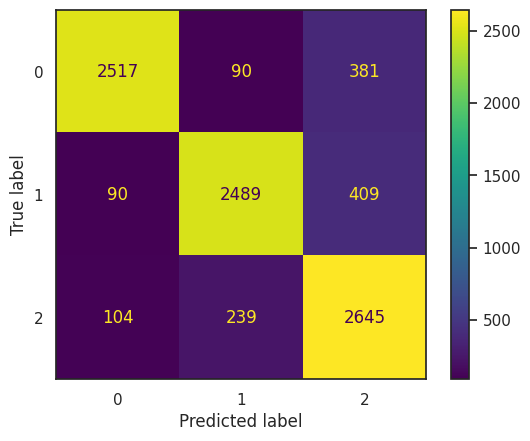

In [66]:
class_report('cleaned-data-distilbert-base-uncased',"train_set",y_train_resampled_true,y_pred_train)

In [67]:
# https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html?highlight=roc#yellowbrick.classifier.rocauc.ROCAUC

In [68]:
# Model Performance Charts

def plot_graphs_accuracy(model:string):
  # Accuracy
  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.savefig(f"/content/img/{model}_accuracy.png")
  plt.show()

def plot_graphs_loss(model:string):
  # Loss
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.savefig(f"/content/img/{model}_loss.png")
  plt.show()

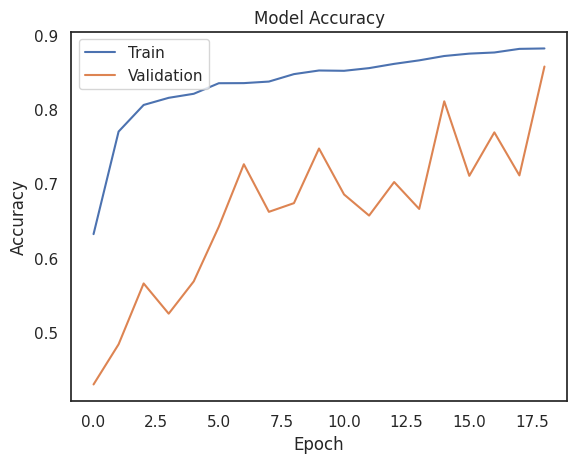

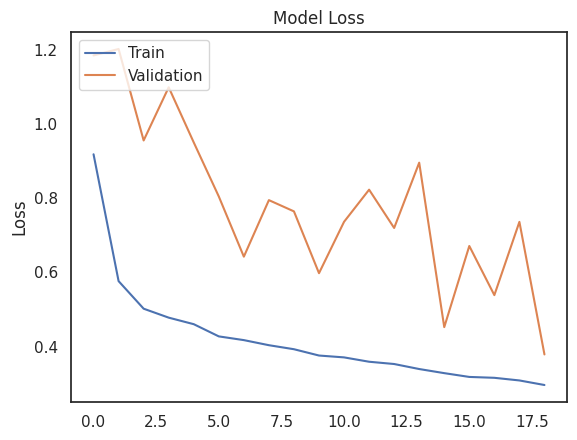

In [69]:
plot_graphs_accuracy('cleaned-data-distilbert-base-uncased')
plot_graphs_loss('cleaned-data-distilbert-base-uncased')

### **Plotting the ROCAUC Curve**

In [70]:
from sklearn.metrics import roc_curve,roc_auc_score, auc

fpr = {}
tpr = {}
roc_auc = {}

lw = 2

classes_by_names = ['mouse','headphone','keyboard_speakers']
# Using args
# https://www.youtube.com/watch?v=Vh__2V2tXUM
# https://www.youtube.com/watch?v=FFpDsC6B2qw
def roc_curve_plot(model_name,model,data,y_true,*args):
  X_features = []
  for feature in args:
    X_features.append(feature)

  y_pred = model.predict(X_features)
  for i in range(len(classes_by_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i],
             lw=lw,
             label=f'ROC of class {classes_by_names[i]}, AUC = {np.round(roc_auc[i],2)}')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right", frameon=True)
  plt.savefig(f"/content/img/{model_name}_{data}_roc_curve.png")
  plt.show()
  roc_auc_scoring_macro_ovr = roc_auc_score(y_true,y_pred,
                                            multi_class="ovr",
                                            average="macro")
  print(f"AUC macro-averaged score over all classes:{np.round(roc_auc_scoring_macro_ovr,2)}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step


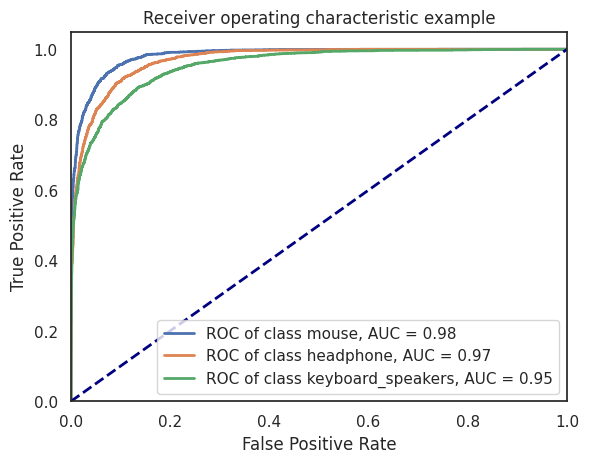

AUC macro-averaged score over all classes:0.97


In [71]:
roc_curve_plot('cleaned-data-distilbert-base-uncased',main_model,"train_set",y_train_resampled,[X_input_ids, X_attention_mask])

{'mouse': 0, 'headphone': 1, 'keyboard_speakers': 2}

### **Model Test & Metrics**

In [72]:
X_test_input_ids = np.zeros((len(X_test),285), dtype = 'int')
X_test_attention_mask = np.zeros((len(X_test),285),  dtype = 'int')
X_test_input_ids,X_test_attention_mask = generate_ids_masks(X_test_input_ids,X_test_attention_mask,X_test['cleaned_review'])

In [73]:
y_pred_test = main_model.predict([X_test_input_ids,X_test_attention_mask])

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


In [74]:
y_test_true = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1093
           1       0.85      0.82      0.83       879
           2       0.70      0.85      0.77       747

    accuracy                           0.83      2719
   macro avg       0.83      0.83      0.82      2719
weighted avg       0.84      0.83      0.83      2719



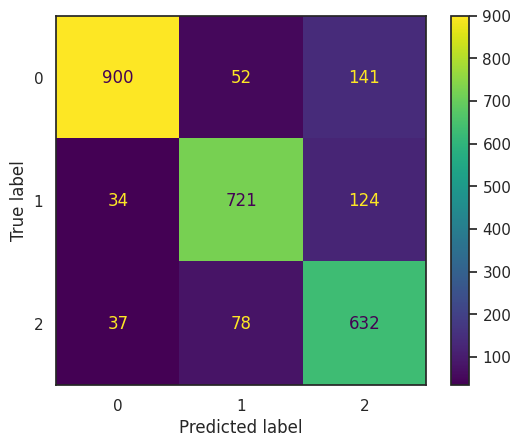

In [75]:
# Classification report test data
class_report('cleaned-data-distilbert-base-uncased',
             "test_set",
             y_test_true,
             y_pred_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


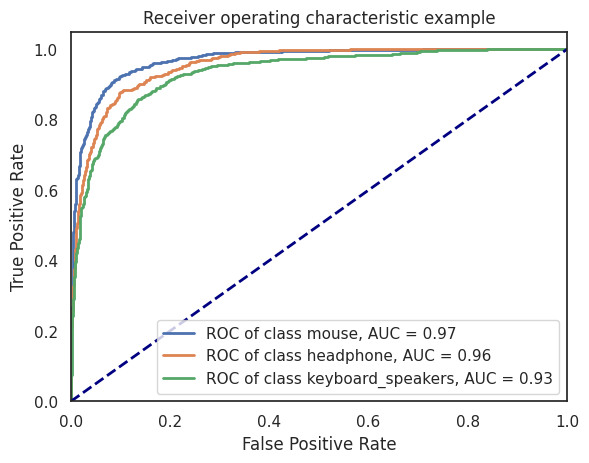

AUC macro-averaged score over all classes:0.95


In [76]:
roc_curve_plot('cleaned-data-distilbert-base-uncased',
               main_model,
               "test_set",
               y_test,
               [X_test_input_ids,X_test_attention_mask])

In [77]:
# # Saving the model
# main_model.save("/content/models/cleaned-data-distilbert-base-uncased-model.keras")